In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
from PIL import Image
import os, sys

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
path = ('../input/covid-xray-dataset/DATA/DATA')
folders = []
for file_name in os.listdir(path):
    folders.append(file_name)

In [5]:
for folder in folders:
    try:

        f = '../input/100-bird-species/train' + folder

        for file in os.listdir(f):
            f_img = f+"/"+file
            img = Image.open(f_img)
            img = img.resize((256,256))
            img.save(f_img)   
            
    except:
        pass

In [6]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/covid-xray-dataset/DATA/DATA",
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
)

Found 3091 files belonging to 2 classes.


2022-01-22 10:07:25.940415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 10:07:26.032292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 10:07:26.032998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 10:07:26.036821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-01-22 10:07:28.306173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1


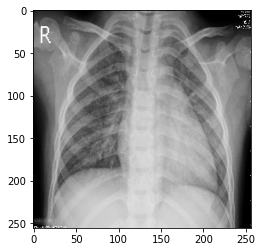

In [7]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    print(df.class_names[label_batch[0].numpy()])

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        
    train_size = int(train_split * len(df))
    val_size = int(val_split * len(df))
    
    train_df = df.take(train_size)    
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    
    return train_df, val_df, test_df

In [9]:
train_df, val_df, test_df = get_dataset_partitions_tf(df)

In [10]:
train_df = train_df.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
preprocess = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
df_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
train_df = train_df.map(
    lambda x, y: (df_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = models.Sequential([
    preprocess,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2, 2),padding='same'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2),padding='same'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2),padding='same'),
    

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=(32,256,256,3))

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 63, 63, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 61, 61, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 31, 31, 64)         

In [17]:
hist = model.fit(
    train_df,
    validation_data = val_df,
    verbose = 1,
    batch_size = 32,
    epochs=30,
    callbacks=[callback]
)

Epoch 1/30


2022-01-22 10:07:44.886087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 100
2022-01-22 10:07:54.869377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 54 of 100
2022-01-22 10:08:02.847244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-01-22 10:08:04.089694: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


77/77 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5767

2022-01-22 10:08:47.476865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-01-22 10:08:48.316192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 3 of 1000


77/77 [==============================] - 77s 544ms/step - loss: 0.6836 - accuracy: 0.5767 - val_loss: 0.6643 - val_accuracy: 0.5799


2022-01-22 10:08:50.916250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 2/30
77/77 [==============================] - 19s 253ms/step - loss: 0.4835 - accuracy: 0.7557 - val_loss: 0.4378 - val_accuracy: 0.8160
Epoch 3/30
77/77 [==============================] - 19s 250ms/step - loss: 0.3413 - accuracy: 0.8547 - val_loss: 0.2915 - val_accuracy: 0.8715
Epoch 4/30
77/77 [==============================] - 20s 258ms/step - loss: 0.2875 - accuracy: 0.8896 - val_loss: 0.2748 - val_accuracy: 0.8889
Epoch 5/30
77/77 [==============================] - 20s 255ms/step - loss: 0.2626 - accuracy: 0.9062 - val_loss: 0.2135 - val_accuracy: 0.9167
Epoch 6/30
77/77 [==============================] - 20s 253ms/step - loss: 0.2580 - accuracy: 0.9010 - val_loss: 0.2835 - val_accuracy: 0.8750
Epoch 7/30
77/77 [==============================] - 20s 257ms/step - loss: 0.2207 - accuracy: 0.9213 - val_loss: 0.2892 - val_accuracy: 0.8646
Epoch 8/30
77/77 [==============================] - 19s 246ms/step - loss: 0.2355 - accuracy: 0.9156 - val_loss: 0.2199 - val_accuracy: 0.9062

In [18]:
model.evaluate(test_df)

2022-01-22 10:12:08.967864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-01-22 10:12:09.392267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2 of 1000


 5/11 [============>.................] - ETA: 0s - loss: 0.2313 - accuracy: 0.9125  

2022-01-22 10:12:09.842284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


11/11 [==============================] - 22s 25ms/step - loss: 0.2230 - accuracy: 0.9204


[0.22304601967334747, 0.9203540086746216]

In [19]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

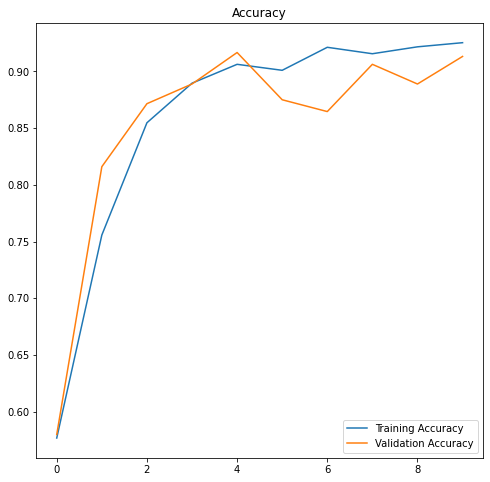

In [20]:
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.show()

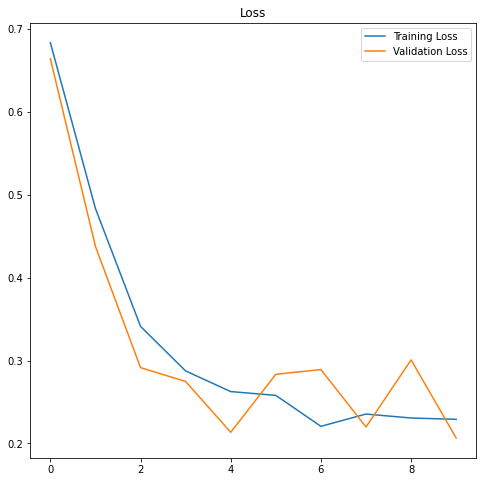

In [21]:
fig,ax = plt.subplots(figsize = (8,8))
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [22]:
model.save('./')

2022-01-22 10:12:51.827155: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
